In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
flist = glob('../plots/bestfits/*')

field = [os.path.basename(U).split('_')[0] for U in flist]
galaxy = np.array([os.path.basename(U.replace('.png','')).split('_')[1] for U in flist]).astype(np.int)

# remove agn

In [4]:
GSD_cat = Table.read(hpath + 'catalogs_for_clear/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',format='ascii')
GND_cat = Table.read(hpath + 'catalogs_for_clear/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat',format='ascii')

agn_ra=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_RA']
agn_dec=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_DEC']

In [5]:
def Match_agn(gal_ra, gal_dec, agn_ra, agn_dec):
    r = (1. / 60 / 60) * 0.5    
    in_out = np.repeat('in',len(gal_ra))          
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(agn_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(agn_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(agn_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                in_out[i]= 'out'
    return in_out

In [6]:
sra = [] ; sdec = []
nra = [] ; ndec = []

for i in range(len(field)):
    if field[i] == 'GSD':
        sra.append(GSD_cat[galaxy[i] - 1]['ra'])
        sdec.append(GSD_cat[galaxy[i] - 1]['dec'])   
    if field[i] == 'GND':
        nra.append(GND_cat[galaxy[i] - 1]['ra'])
        ndec.append(GND_cat[galaxy[i] - 1]['dec']) 

In [7]:
south_agn = Match_agn(sra,sdec,agn_ra,agn_dec)

In [8]:
n_agn_cat=Table.read('../../../Clear_data/AGN_catalog/apjs523032t3_mrt.txt',format='ascii')

In [9]:
RA=np.array([n_agn_cat['RAh'].data, n_agn_cat['RAm'].data,n_agn_cat['RAs'].data]).T
DEC=np.array([n_agn_cat['DEd'].data,n_agn_cat['DEm'].data,n_agn_cat['DEs'].data]).T

def Convert_RA_DEC_to_deg(ra,dec):
    R=15*(ra[0]+ra[1]/60.+ra[2]/3600.)
    D=dec[0]+dec[1]/60.+dec[2]/3600.
    return R,D

nra_agn,ndec_agn=np.zeros([2,len(RA)])

for i in range(len(RA)):
    nra_agn[i],ndec_agn[i]=Convert_RA_DEC_to_deg(RA[i],DEC[i])

In [10]:
north_agn = Match_agn(nra,ndec,nra_agn,ndec_agn)

In [11]:
north_agn

array(['in', 'in', 'in', 'ou', 'in', 'in', 'in', 'in', 'in', 'in', 'in',
       'in', 'in', 'in', 'in', 'in', 'in', 'ou', 'in', 'in', 'in', 'in',
       'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in',
       'in', 'in', 'in', 'in', 'in', 'in'], dtype='<U2')

In [12]:
south_agn

array(['in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'ou',
       'in', 'in', 'in', 'in', 'ou', 'in'], dtype='<U2')

In [13]:
u=0
v=0

upd_field = []
upd_galaxy = []


for i in range(len(field)):
    if field[i] == 'GSD':
        if south_agn[u] == 'ou':
            print(field[i], galaxy[i], 'out')
        else:
            upd_field.append(field[i])
            upd_galaxy.append(galaxy[i])
            
        u+=1
        
    if field[i] == 'GND':
        if north_agn[v] == 'ou':
            print(field[i], galaxy[i], 'out')
            
        else:
            upd_field.append(field[i])
            upd_galaxy.append(galaxy[i])
        v+=1

GND 15490 out
GND 23631 out
GSD 42113 out
GSD 46846 out


In [14]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

In [16]:
PWV , BWV, RWV =[[],[],[]]
PIE , BIE, RIE =[[],[],[]]
PE , BE, RE =[[],[],[]]
PWV_rf , BWV_rf, RWV_rf =[[],[],[]]

for i in range(len(upd_field)):
    bfZ, bft, bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bfz, bfd =np.load('../data/bestfits/{0}_{1}_bestfit.npy'.format(field[i],
                                                                                                                              galaxy[i]))
    
    def Time_bins(agelim):
        lbt = np.array([0, 0.1, 0.3, 0.6, 1, 1.5])
        return np.round(agelim  - lbt / 2.1 * agelim, 2)[::-1]

    agelim = Oldest_galaxy(bfz)
    LBT = Time_bins(agelim)
    
    sp.params['logzsol'] = np.log10(bfZ)
    sp.params['dust2'] = bfd
    sp.set_tabular_sfh(LBT, np.array([bftau1, bftau2, bftau3, bftau4, bftau5, bftau6]))
    wave,flux = sp.get_spectrum(tage = bft, peraa = True)
    
    ## use premade option to simulate spectra
    
    Gs = Gen_spec(field[i],galaxy[i], bfz,g102_lims=[8300, 11288], g141_lims=[11288, 16500],
              mdl_err = False,phot_errterm = 0.0, decontam = True) 
    
    Gs.Sim_all_premade(wave*(1+bfz),flux)
       
    PWV.extend(Gs.Pwv)
    PWV_rf.extend(Gs.Pwv / (1 + bfz))
    
    PIE.extend( (((Gs.Pflx - Gs.Pmfl) / Gs.Pflx)**2))
    PE.extend( (((Gs.Perr) / Gs.Pflx)**2) ) 
    
    if Gs.g102: 

        BWV.extend(Gs.Bwv)
        BWV_rf.extend(Gs.Bwv/ (1 + bfz))
        
        BIE.extend(((Gs.Bfl - Gs.Bmfl) / Gs.Bfl)**2)
        BE.extend((Gs.Ber/Gs.Bfl)**2) 

    if Gs.g141:
        RWV.extend(Gs.Rwv)
        RWV_rf.extend(Gs.Rwv/ (1 + bfz))
        RIE.extend( ((Gs.Rfl - Gs.Rmfl) / Gs.Rfl )**2 )
        RE.extend( (Gs.Rer/Gs.Rfl)**2)

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [17]:
def Run_bin_stat(wv,tmp,bin_size):
    wv = wv[tmp**2 > 0]
    tmp = tmp[tmp**2 > 0]
    
    
    wv_med = [] ; wv_mean = [] ; binned_data = []

    low_lim = min(wv)
    while low_lim <= max(wv):
        IDX = [U for U in range(len(wv)) if low_lim <= wv[U] < low_lim + bin_size]
        wv_med.append(np.median(wv[IDX]))
        wv_mean.append(np.median(low_lim + bin_size / 2))
        binned_data.append(np.median(tmp[IDX]))
        low_lim += bin_size
    return np.array(wv_med), np.array(wv_mean), np.array(binned_data)

In [18]:
def Roll_bin_stat(wv,tmp,bin_size):
    wv = wv[tmp**2 > 0]
    tmp = tmp[tmp**2 > 0]
    
    
    wv_med = [] ; wv_mean = [] ; binned_data = []

    i=0
    low_lim = wv[i]
    while low_lim < max(wv):
        IDX = [U for U in range(len(wv)) if low_lim <= wv[U] < low_lim + bin_size]
        wv_med.append(np.median(wv[IDX]))
        wv_mean.append(np.median(low_lim + bin_size / 2))
        binned_data.append(np.median(tmp[IDX]))
        i+=1
        low_lim = wv[i]
    return np.array(wv_med), np.array(wv_mean), np.array(binned_data)

In [33]:
IDPO = np.argsort(PWV)
IDBO = np.argsort(BWV)
IDRO = np.argsort(RWV)

IDPR = np.argsort(PWV_rf)
IDBR = np.argsort(BWV_rf)
IDRR = np.argsort(RWV_rf)

In [20]:
pwm = np.array(PWV_rf)[IDPR]
pie = np.array(PIE)[IDPR]
pe = np.array(PE)[IDPR]

bwm = np.array(BWV_rf)[IDBR]
bie = np.array(BIE)[IDBR]
be = np.array(BE)[IDBR]

rwm = np.array(RWV_rf)[IDRR]
rie = np.array(RIE)[IDRR]
re = np.array(RE)[IDRR]

priw_med, priw_mean, prie_bin = Roll_bin_stat(np.log10(pwm), pie,.05)
prw_med, prw_mean, pre_bin = Roll_bin_stat(np.log10(pwm),pe,.05)
prmw_med, prmw_mean, prme_bin = Roll_bin_stat(np.log10(pwm),np.sqrt(pie - pe),.05)

briw_med, briw_mean, brie_bin = Roll_bin_stat(bwm, bie, 100)
brw_med, brw_mean, bre_bin = Roll_bin_stat(bwm, be, 100)
brmw_med, brmw_mean, brme_bin = Roll_bin_stat(bwm, np.sqrt(bie - be), 100)

rriw_med, rriw_mean, rrie_bin = Roll_bin_stat(rwm, rie,100)
rrw_med, rrw_mean, rre_bin = Roll_bin_stat(rwm, re,100)
rrmw_med, rrmw_mean, rrme_bin = Roll_bin_stat(rwm, np.sqrt(rie - re),100)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encounte

In [34]:
pwo = np.array(PWV)[IDPO]
pieo = np.array(PIE)[IDPO]
peo = np.array(PE)[IDPO]

bwo = np.array(BWV)[IDBO]
bieo = np.array(BIE)[IDBO]
beo = np.array(BE)[IDBO]

rwo = np.array(RWV)[IDRO]
rieo = np.array(RIE)[IDRO]
reo = np.array(RE)[IDRO]

poiw_med, poiw_mean, poie_bin = Roll_bin_stat(np.log10(pwo), pieo,.05)
pow_med, pow_mean, poe_bin = Roll_bin_stat(np.log10(pwo),peo,.05)
pomw_med, pomw_mean, pome_bin = Roll_bin_stat(np.log10(pwo),np.sqrt(pieo - peo),.05)

boiw_med, boiw_mean, boie_bin = Roll_bin_stat(bwo, bieo, 100)
bow_med, bow_mean, boe_bin = Roll_bin_stat(bwo, beo, 100)
bomw_med, bomw_mean, bome_bin = Roll_bin_stat(bwo, np.sqrt(bieo - beo), 100)

roiw_med, roiw_mean, roie_bin = Roll_bin_stat(rwo, rieo,100)
row_med, row_mean, roe_bin = Roll_bin_stat(rwo, reo,100)
romw_med, romw_mean, rome_bin = Roll_bin_stat(rwo, np.sqrt(rieo - reo),100)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


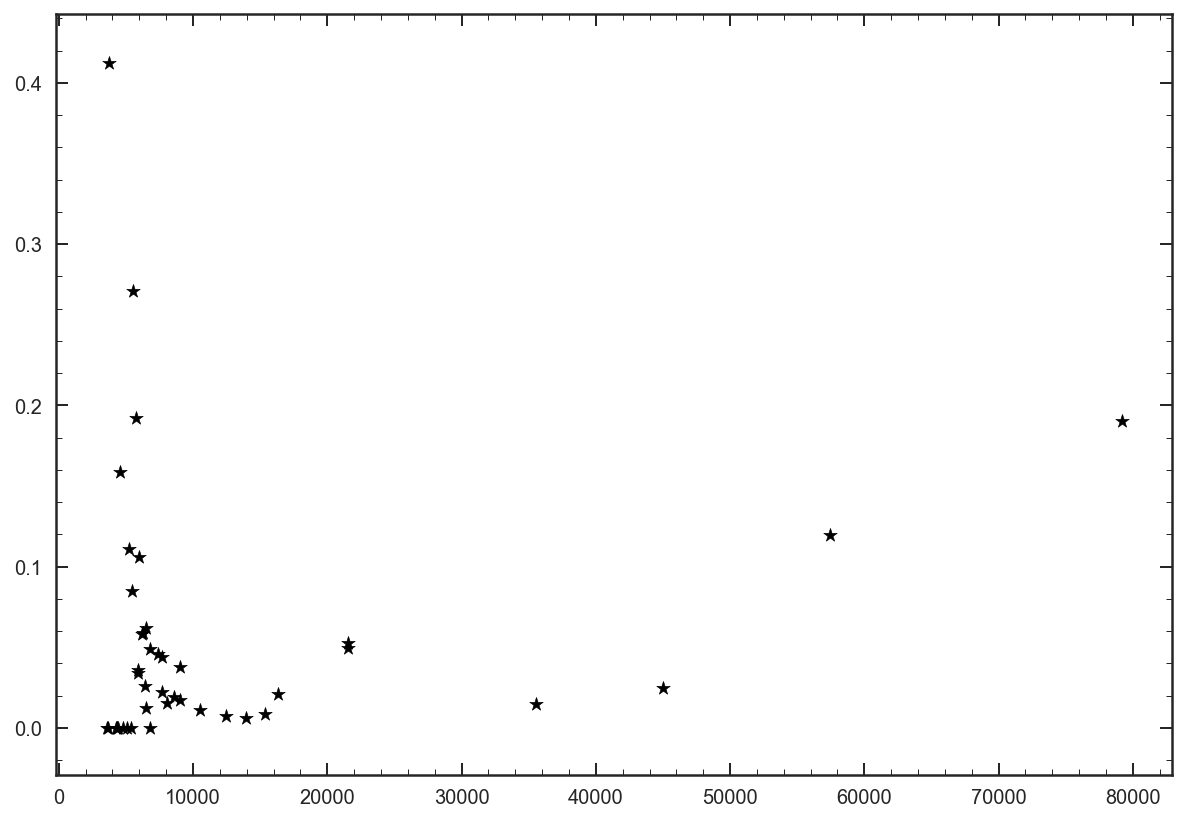

In [102]:
wvbin = []
ibin = []
ebin = []

init_wv= 0
for i in range(len(pwo)):
    
    if pwo[i] != init_wv:
        init_wv = pwo[i]
        wvbin.append(pwo[i])
        errbin = []
        iebin = []
        u = i
        
        while pwo[u] == pwo[i] and u < len(pwo)-1:
            errbin.append(peo[u])
            iebin.append(pieo[u])
            u+=1
            
        ibin.append(np.median(iebin))
        ebin.append(np.median(errbin))  
        
        
wvbin = np.array(wvbin)
ibin = np.array(ibin)
ebin = np.array(ebin)

instr_err = np.sqrt(ibin - ebin)
instr_err[~(instr_err**2 > 0)] = 0

plt.figure(figsize=[10,7])
plt.scatter(wvbin, instr_err, color = 'k', marker= '*', s = 50)

pwvbin = wvbin
pinstr_err = instr_err

np.save('../templates/P_inst_EF.npy', [pwvbin,pinstr_err])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


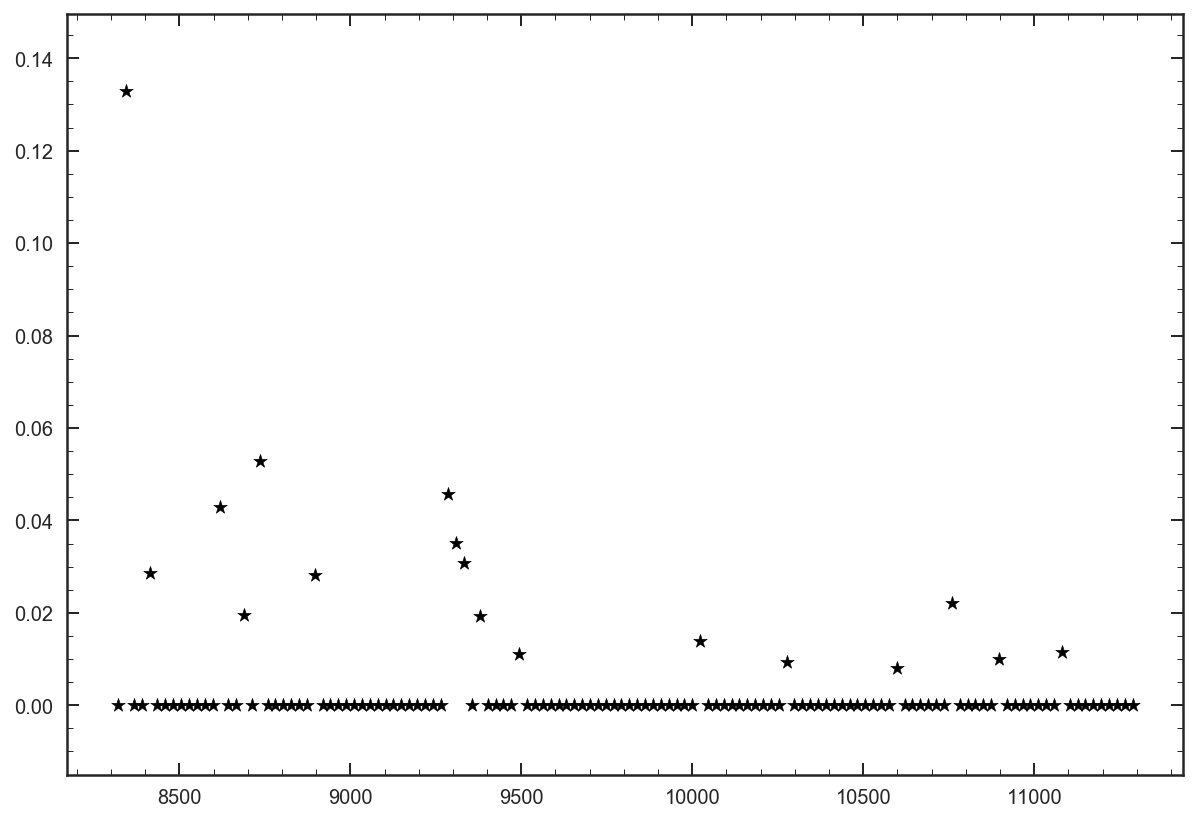

In [77]:
wvbin = []
ibin = []
ebin = []

init_wv= 0
for i in range(len(bwo)):
    
    if bwo[i] != init_wv:
        init_wv = bwo[i]
        wvbin.append(bwo[i])
        errbin = []
        iebin = []
        u = i
        
        while bwo[u] == bwo[i] and u < len(bwo)-1:
            errbin.append(beo[u])
            iebin.append(bieo[u])
            u+=1
            
        ibin.append(np.median(iebin))
        ebin.append(np.median(errbin))  
        
        
wvbin = np.array(wvbin)
ibin = np.array(ibin)
ebin = np.array(ebin)

instr_err = np.sqrt(ibin - ebin)
instr_err[~(instr_err**2 > 0)] = 0

plt.figure(figsize=[10,7])
plt.scatter(wvbin, instr_err, color = 'k', marker= '*', s = 50)

bwvbin = wvbin
binstr_err = instr_err

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


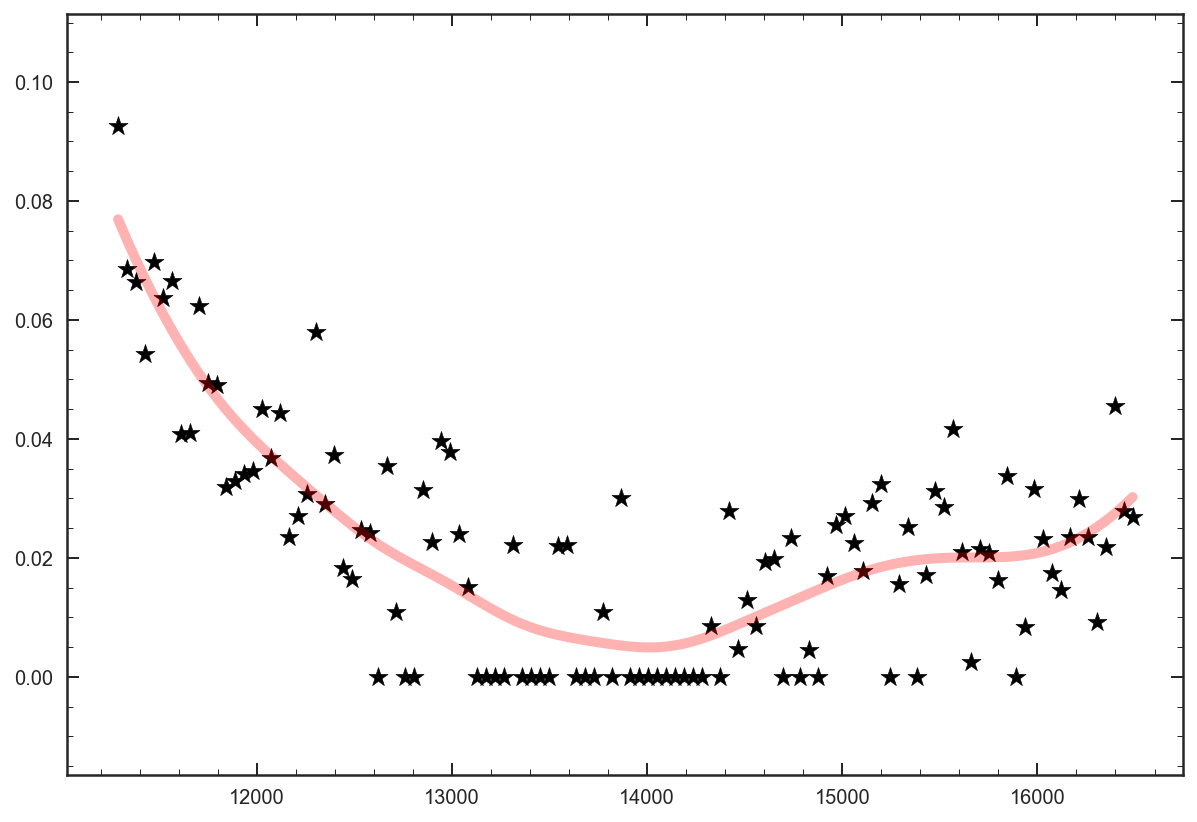

In [103]:
wvbin = []
ibin = []
ebin = []

init_wv= 0
for i in range(len(rwo)):
    
    if rwo[i] != init_wv:
        init_wv = rwo[i]
        wvbin.append(rwo[i])
        errbin = []
        iebin = []
        u = i
        
        while rwo[u] == rwo[i] and u < len(rwo)-1:
            errbin.append(reo[u])
            iebin.append(rieo[u])
            u+=1
            
        ibin.append(np.median(iebin))
        ebin.append(np.median(errbin))  
        
        
wvbin = np.array(wvbin)
ibin = np.array(ibin)
ebin = np.array(ebin)

instr_err = np.sqrt(ibin - ebin)
instr_err[~(instr_err**2 > 0)] = 0

plt.figure(figsize=[10,7])
plt.scatter(wvbin, instr_err, color = 'k', marker= '*', s = 100)
plt.plot(wvbin, Smooth(instr_err,wvbin,300),'r',linewidth=5, alpha=0.3)

rwvbin = wvbin
rinstr_err = instr_err

np.save('../templates/R_inst_EF.npy', [rwvbin,rinstr_err])

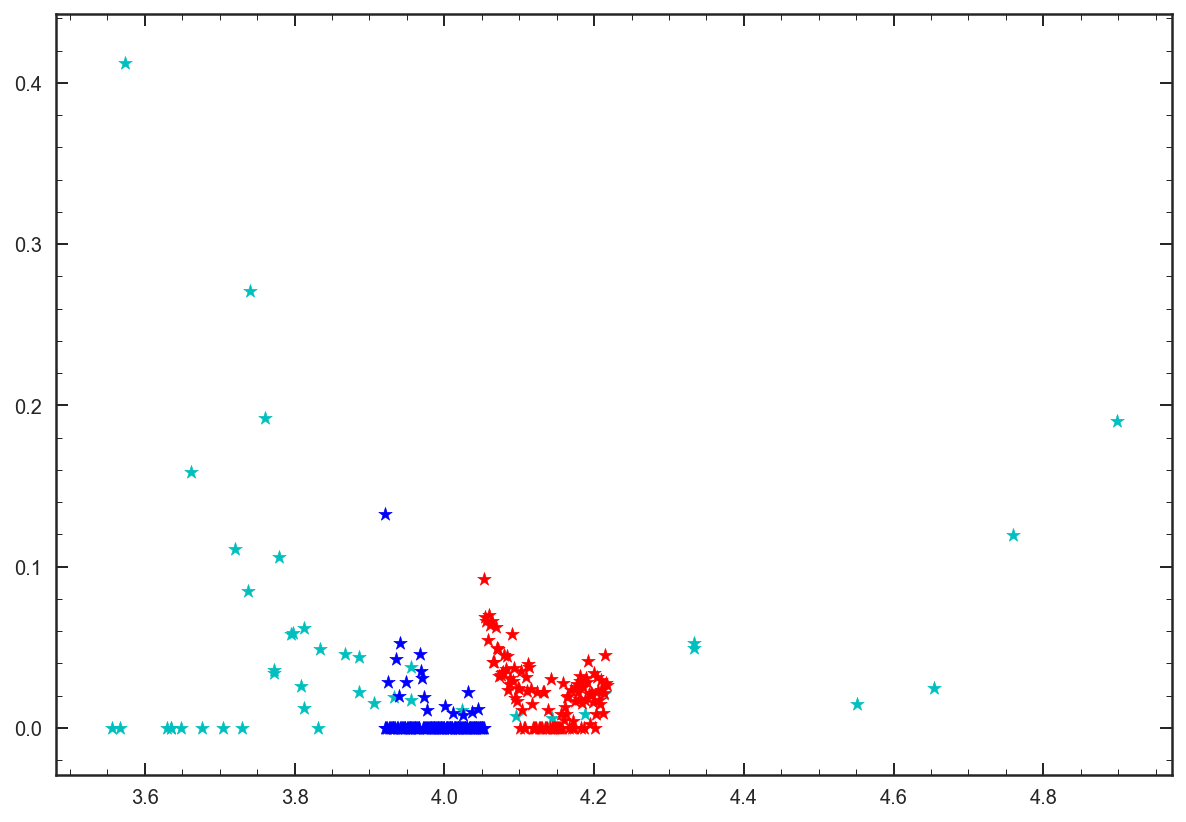

In [81]:
plt.figure(figsize=[10,7])
plt.scatter(np.log10(pwvbin), pinstr_err, color = 'c', marker= '*', s = 50)
plt.scatter(np.log10(bwvbin), binstr_err, color = 'b', marker= '*', s = 50)
plt.scatter(np.log10(rwvbin), rinstr_err, color = 'r', marker= '*', s = 50)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


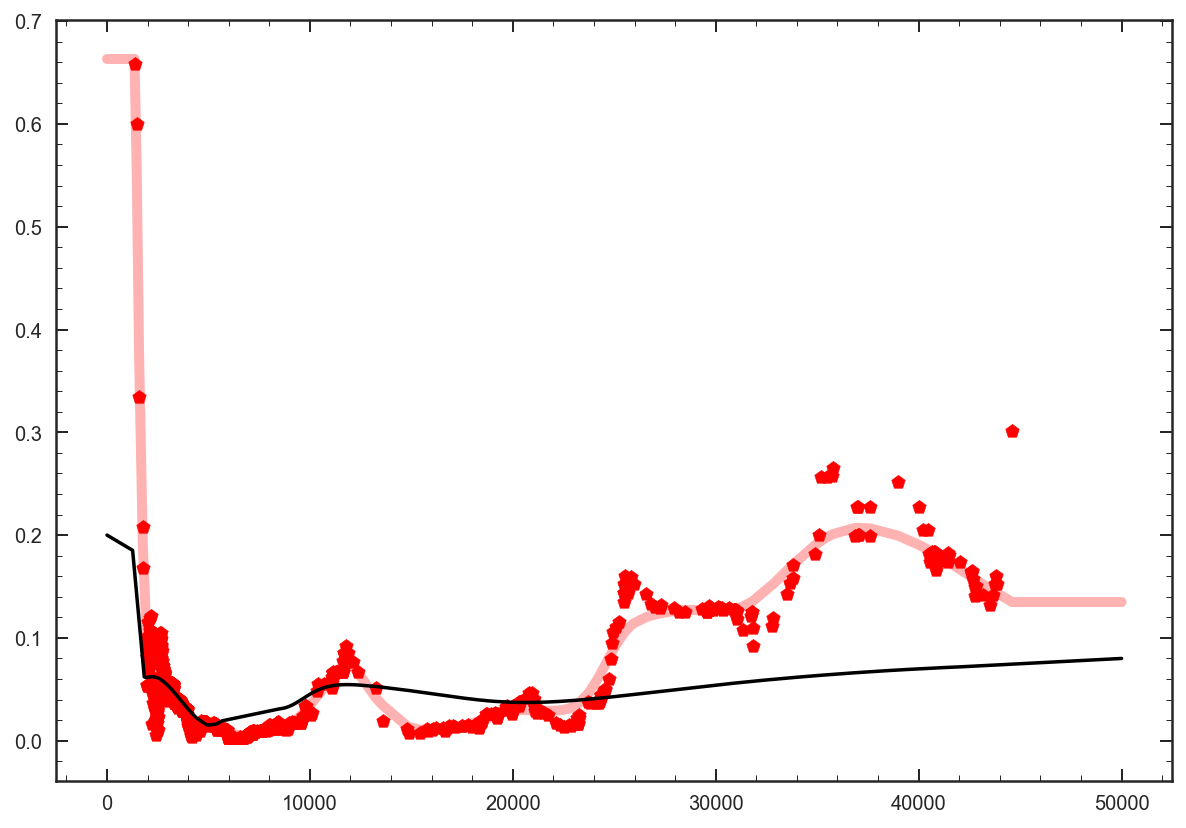

In [106]:
priw_med, priw_mean, prie_bin = Roll_bin_stat(np.log10(pwm), pie,.05)
prw_med, prw_mean, pre_bin = Roll_bin_stat(np.log10(pwm),pe,.05)

photwv,photierr = np.load('../templates/P_mdl_EF.npy')

plt.figure(figsize=[10,7])
plt.scatter(10**prw_med, np.sqrt(prie_bin - pre_bin) , marker = 'p', s=50,color = 'r')

pmebin = np.sqrt(prie_bin - pre_bin)

mpwv = 10**prw_med[pmebin**2 > 0]
mpie = Smooth(pmebin[pmebin**2 > 0],prw_med[pmebin**2 > 0],0.025)

mpwv = np.append(np.append(photwv[0],mpwv),photwv[-1])
mpie = np.append(np.append(mpie[0],mpie),mpie[-1])

plt.plot(mpwv, mpie,'r',linewidth=5, alpha=0.3)

plt.plot(photwv,photierr,'k')

np.save('../templates/P_mdl_EF.npy', [mpwv, mpie])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


(0, 1)

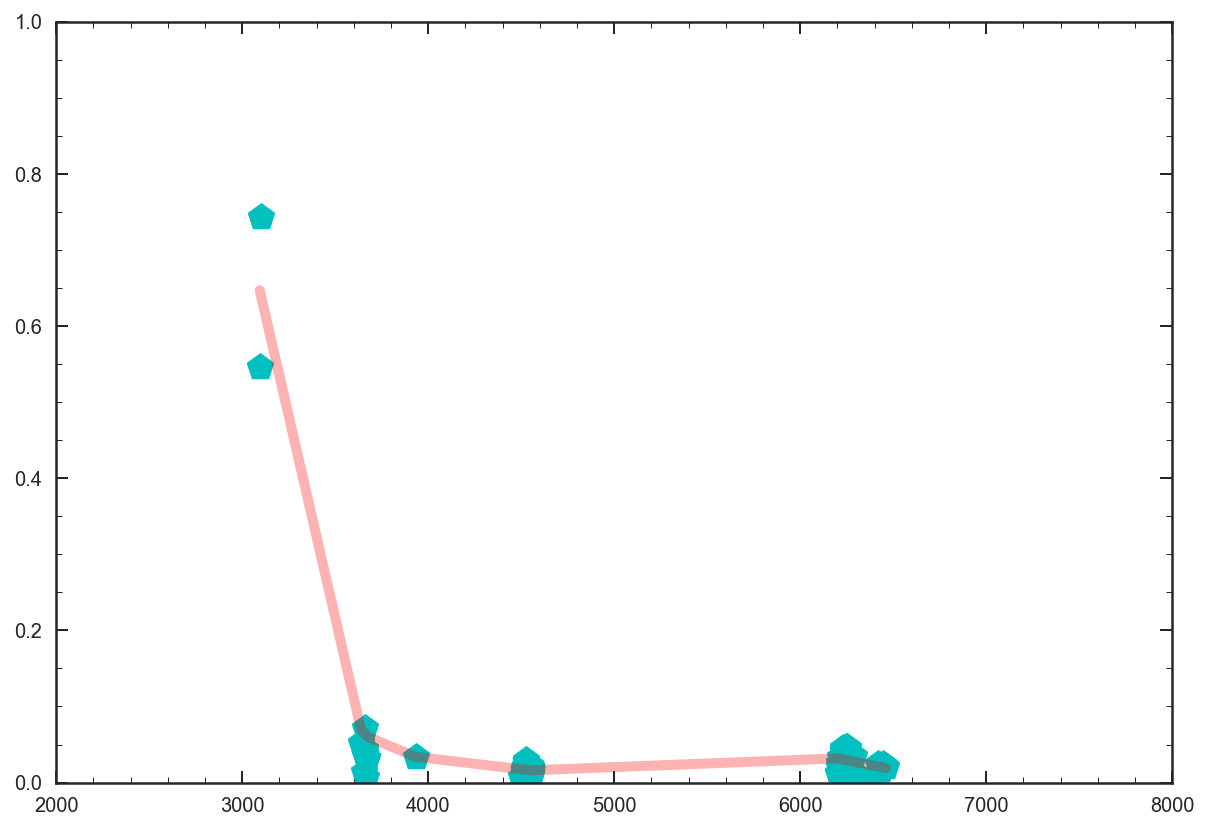

In [22]:
briw_med, briw_mean, brie_bin = Roll_bin_stat(bwm, bie, 75)
brw_med, brw_mean, bre_bin = Roll_bin_stat(bwm, be, 75)

plt.figure(figsize=[10,7])

# plt.scatter(bwm, bie , s=10,color = 'b')
# plt.scatter(briw_med, brie_bin , marker = 'p', s=50,color = 'b')
# plt.scatter(bwm, be , s=10,color = 'r')
# plt.scatter(brw_med, bre_bin , marker = 'p', s=50,color = 'k')
plt.scatter(brw_med, np.sqrt(brie_bin - bre_bin) , marker = 'p', s=200,color = 'c')
# plt.scatter(brmw_med, brme_bin , marker = 'p', s=200 ,color = 'r')

bmebin = np.sqrt(brie_bin - bre_bin)

# plt.plot(AW, AI, 'o', color='g',ms=10)
# plt.plot(bmw_med, Smooth(bme_bin,rmw_med,50),'r',linewidth=5, alpha=0.3)
plt.plot(brw_med[bmebin**2 >0], Smooth(bmebin[bmebin**2 >0],brw_med[bmebin**2 >0],300),'r',linewidth=5, alpha=0.3)

plt.xlim(2000,8000)
plt.ylim(0,1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


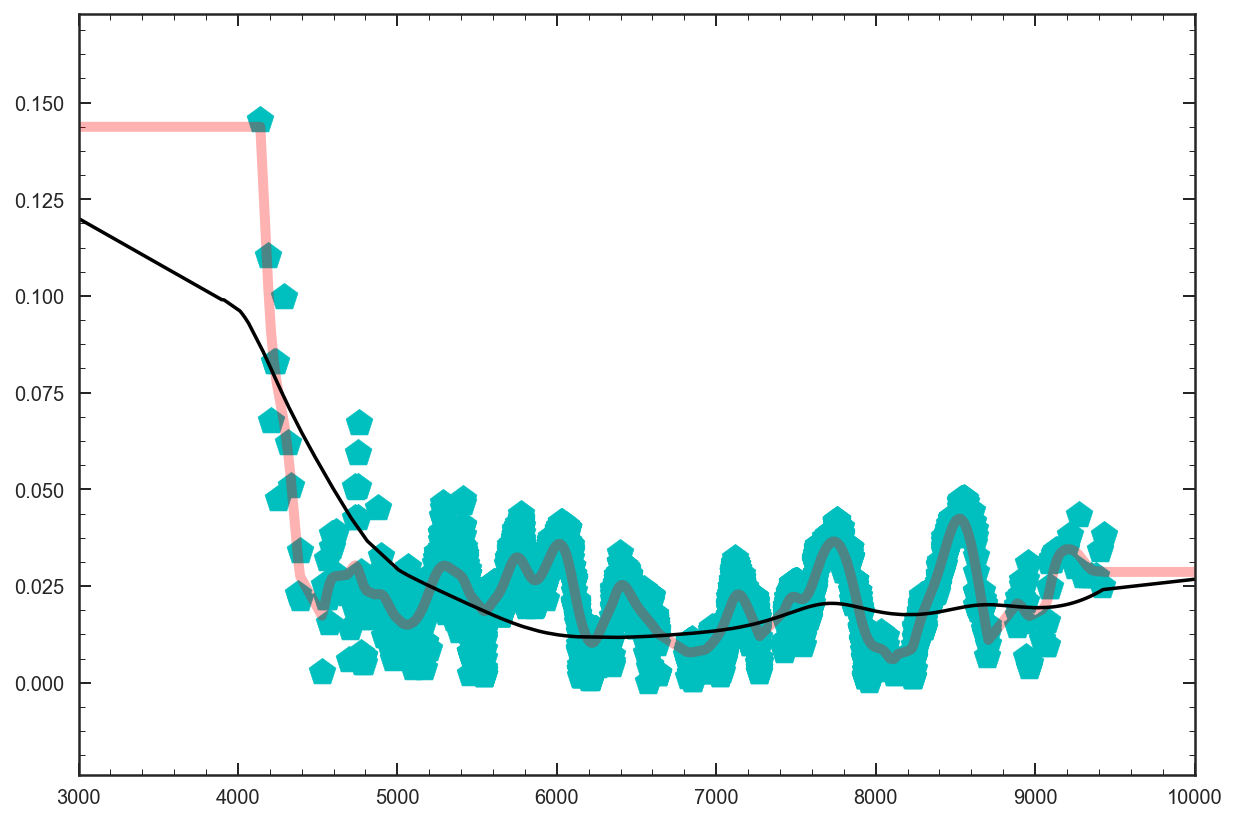

In [110]:
# rriw_med, rriw_mean, rrie_bin = Roll_bin_stat(rwm, rie,100)
# rrw_med, rrw_mean, rre_bin = Roll_bin_stat(rwm, re,100)
# rrmw_med, rrmw_mean, rrme_bin = Roll_bin_stat(rwm, np.sqrt(rie - re),500)

g141wv, g141ierr = np.load('../templates/R_mdl_EF.npy')

mrwv = rrw_med[rmebin**2 >0]
mrie = Smooth(rmebin[rmebin**2 >0],rrw_med[rmebin**2 >0],50)

mrwv = np.append(np.append(g141wv[0],mrwv),g141wv[-1])
mrie = np.append(np.append(mrie[0],mrie),mrie[-1])

plt.figure(figsize=[10,7])
plt.scatter(rrw_med, np.sqrt(rrie_bin - rre_bin) , marker = 'p', s=200,color = 'c')
plt.plot(mrwv, mrie,'r',linewidth=5, alpha=0.3)

plt.xlim(3000,10000)
plt.plot(g141wv,g141ierr,'k')

np.save('../templates/R_mdl_EF.npy', [mrwv, mrie])

In [80]:
PWV = 10**prw_med[pmebin**2 > 0]
PMDLER = Smooth(pmebin[pmebin**2 > 0], prw_med[pmebin**2 > 0], 0.1)

RWV = rrw_med[rmebin**2 >0]
RMDLER = Smooth(rmebin[rmebin**2 >0], rrw_med[rmebin**2 >0], 300)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [81]:
PWV = np.append(np.append(1,PWV),50000)
PMDLER = np.append(np.append(0.2,PMDLER),0.08)

RWV = np.append(np.append(3001,RWV),15000)
RMDLER = np.append(np.append(0.12,RMDLER),0.05)

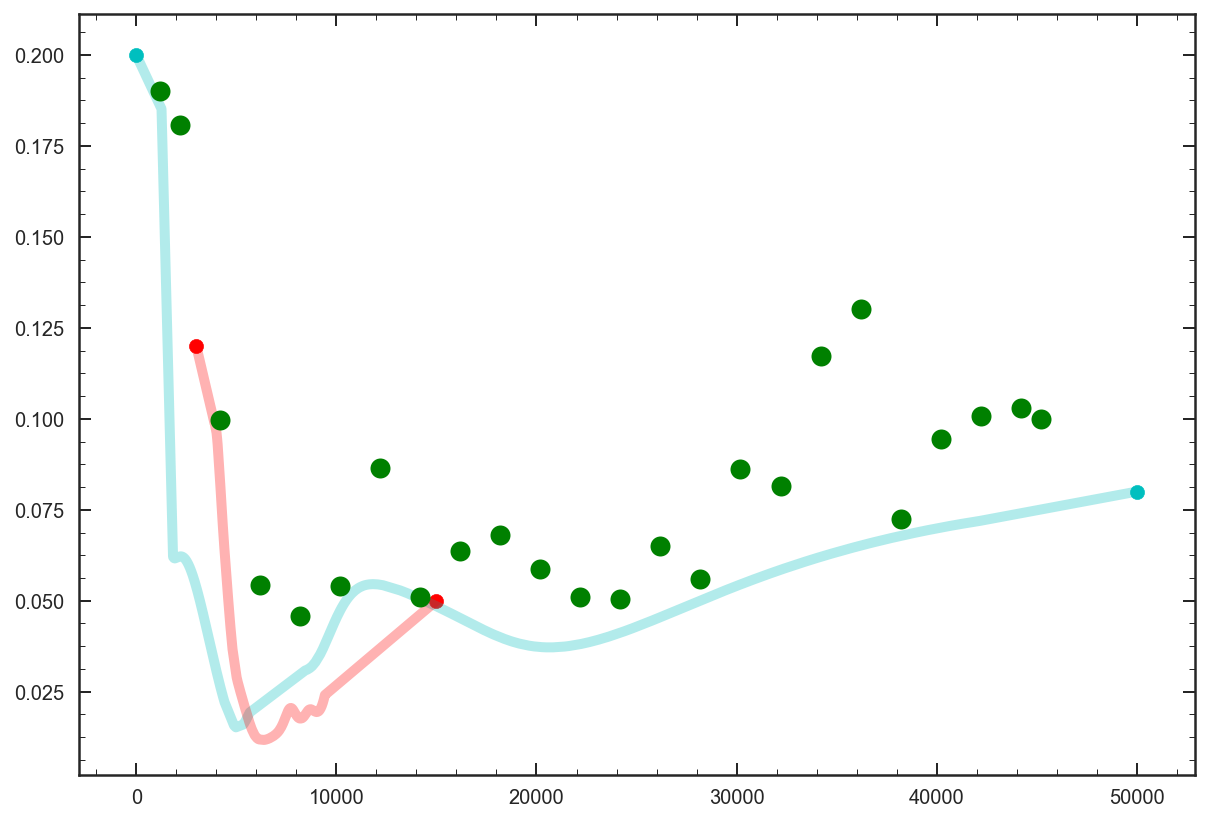

In [82]:
plt.figure(figsize=[10,7])

plt.plot(PWV, PMDLER,'c',linewidth=5, alpha=0.3)
plt.scatter(50000, 0.08,marker = 'o', color = 'c', s=50)
plt.scatter(1, 0.2,marker = 'o', color = 'c', s=50)

plt.plot(RWV, RMDLER,'r',linewidth=5, alpha=0.3)
plt.scatter(15000, 0.05,marker = 'o', color = 'r', s=50)
plt.scatter(3001, 0.12,marker = 'o', color = 'r', s=50)

plt.plot(AW, AI, 'o', color='g',ms=10)

# plt.ylim(0,0.2)

In [83]:
np.save('../templates/P_mdl_EF',[PWV, PMDLER])
np.save('../templates/R_mdl_EF',[RWV, RMDLER])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


(0, 1)

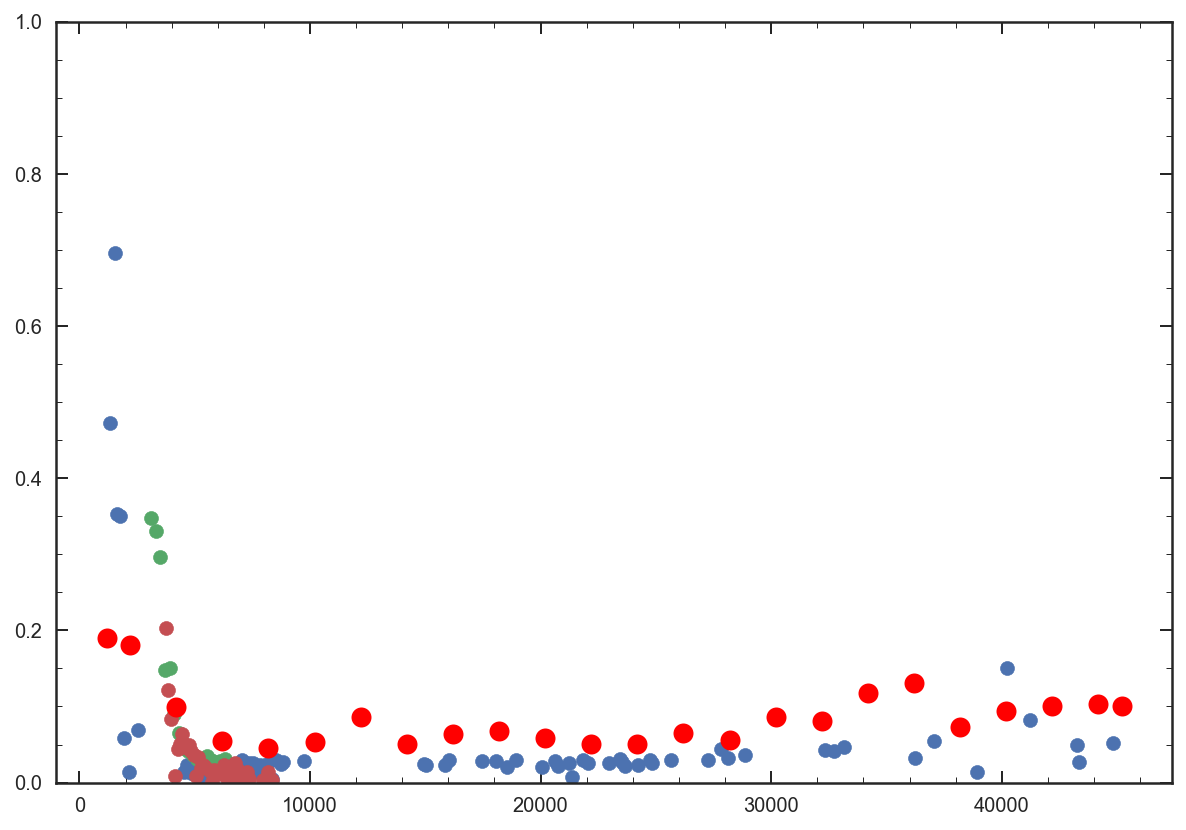

In [20]:
plt.figure(figsize=[10,7])
plt.scatter(P_mean, np.sqrt(P_bin - PI_bin))
plt.scatter(B_mean, np.sqrt(B_bin - BI_bin))

plt.scatter(R_mean, np.sqrt(R_bin - RI_bin))

plt.plot(AW, AI, 'o', color='r',ms=10)
plt.ylim(0,1)

In [12]:
all_W = np.append(np.append(PWM,BWM),RWM)
all_I = np.append(np.append(PIM,BIM),RIM)

IDA = np.argsort(all_W)

In [15]:
all_med, all_mean, all_bin = Run_bin_stat(all_W, all_I,2000)

In [16]:
all_mean = all_mean[all_bin**2 > 0]
all_bin = all_bin[all_bin**2 > 0]

In [11]:
AW = [1195, 2195,  4195,  6195,  8195,10195, 12195, 14195, 16195,18195, 20195, 22195, 24195,
       26195, 28195, 30195, 32195, 34195, 36195, 38195, 40195,42195, 44195, 45195]

AI = [0.19, 0.18073661, 0.09971768, 0.05432547, 0.04576962, 0.05394993,
       0.08650354, 0.05108179, 0.06362486, 0.06819532, 0.05876188,
       0.05115314, 0.05055882, 0.06502043, 0.05591874, 0.08630462,
       0.08148806, 0.11726747, 0.13029932, 0.07259313, 0.09453249,
       0.10071725, 0.10291831, 0.1]

(0, 1.75)

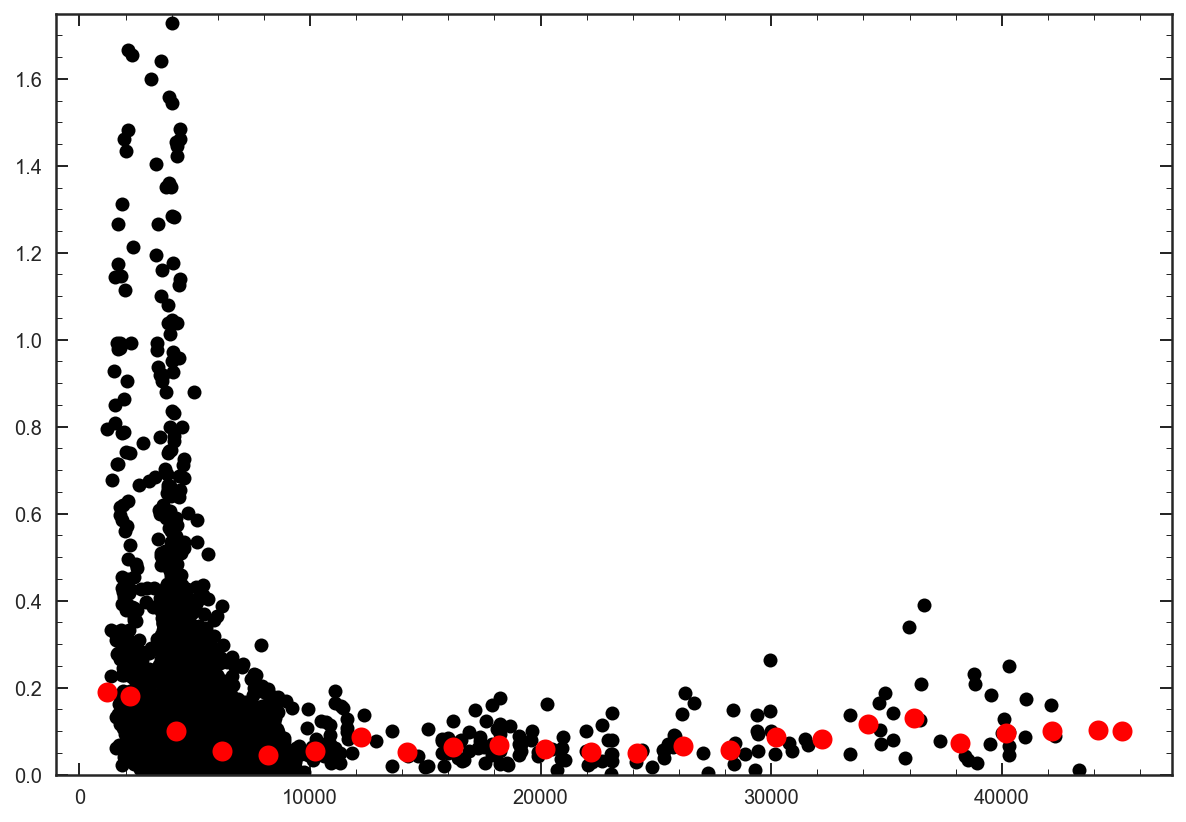

In [19]:
plt.figure(figsize=[10,7])
plt.plot(all_W[IDA], all_I[IDA], 'o', color='k')
plt.plot(AW, AI, 'o', color='r',ms=10)

# plt.plot(awv, amef)
# plt.plot(awv, amef,'o')
# plt.plot(awv, Smooth(amef,awv,500),'c',linewidth=5, alpha=0.3)
# plt.plot(all_mean, Smooth(all_bin,all_mean,1000),'c',linewidth=5, alpha=0.3)
plt.ylim(0,1.75)
# plt.xlim(0,4000)
# plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [97]:
awv = np.arange(500, max(PWV_rf) + 500, 500)
amef = [1.4,1.4, 0.4, 0.12, 0.09, 0.07, 0.06, 0.05, 0.035, 0.025, 0.02, 0.015,
       0.015, 0.015, 0.02, 0.03, 0.035, 0.04, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# rwvs = np.arange(min(RWV), max(RWV) + 10, 5)
# irief = interp1d(rwv,rief)(rwvs)

In [100]:
awv,amef = np.load('../templates/mdl_EF.npy')

In [140]:
PWM = 10**PWVR_mean
PIM = np.sqrt(PME_bin-PE_bin)

BWM = BWVR_mean
BIM = np.sqrt(BME_bin-BE_bin)

RWM = RWVR_mean
RIM = np.sqrt(RME_bin-RE_bin)

PWM = PWM[PIM**2 > 0]
PIM = PIM[PIM**2 > 0]
BWM = BWM[BIM**2 > 0]
BIM = BIM[BIM**2 > 0]
RWM = RWM[RIM**2 > 0]
RIM = RIM[RIM**2 > 0]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered

In [142]:
all_W = np.append(np.append(PWM,BWM),RWM)
all_I = np.append(np.append(PIM,BIM),RIM)

IDA = np.argsort(all_W)

(0, 4000)

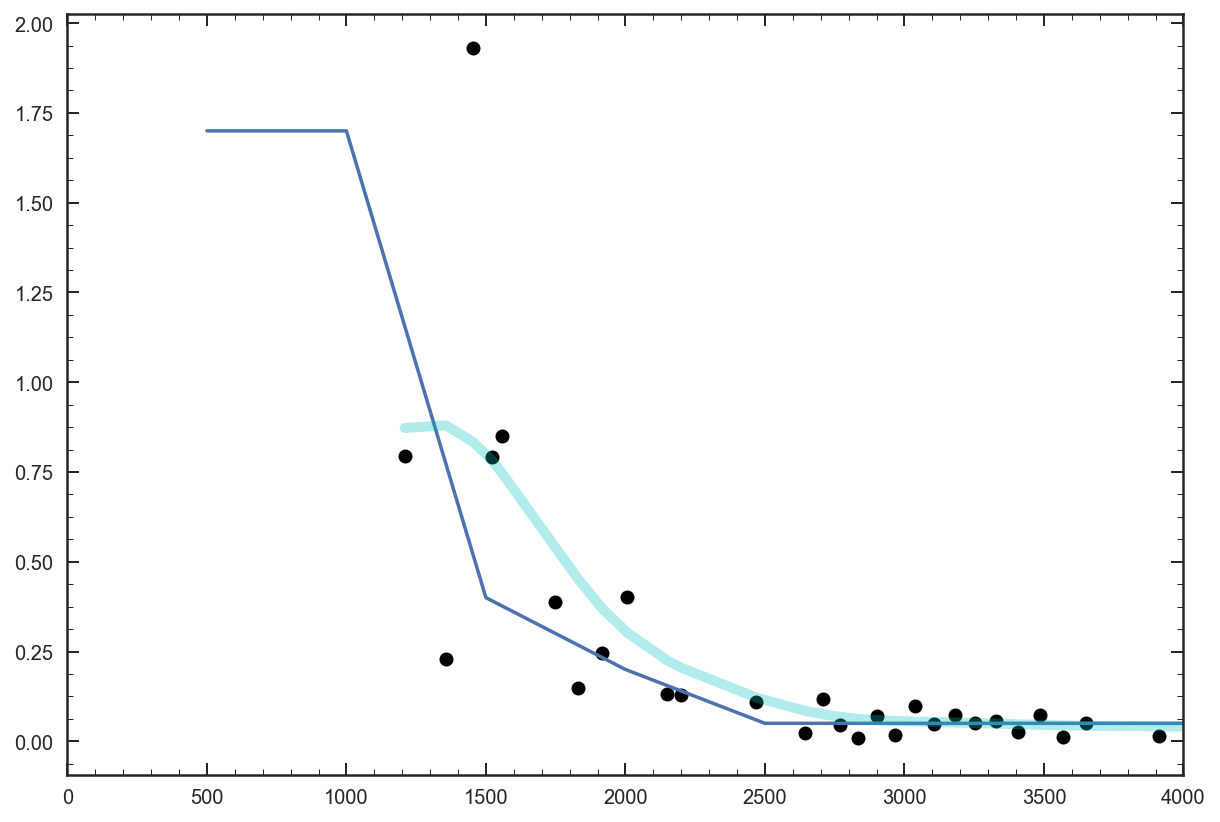

In [155]:
plt.figure(figsize=[10,7])
# plt.plot(PWM, PIM, 'o', color='#984ea3')
# plt.plot(BWM, BIM, 'o', color='#377eb8')
# plt.plot(RWM, RIM, 'o', color='#e41a1c')
plt.plot(all_W[IDA], all_I[IDA], 'o', color='k')
plt.plot(awv, amef)
# plt.plot(awv, amef,'o')
# plt.plot(awv, Smooth(amef,awv,500),'c',linewidth=5, alpha=0.3)
plt.plot(all_W[IDA], Smooth(all_I[IDA],all_W[IDA],300),'c',linewidth=5, alpha=0.3)

plt.xlim(0,4000)
# plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [135]:
awv = np.arange(500, max(PWV_rf) + 500, 500)
amef = [1.7,1.7, 0.4, 0.2, 0.05, 0.05, 0.05, 0.05, 0.035, 0.025, 0.02, 0.015,
       0.015, 0.015, 0.02, 0.03, 0.035, 0.04, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [215]:
np.save('../templates/mdl_EF',[AW,AI])

In [ ]:
PWV , BWV, RWV =[[],[],[]]
PIE , BIE, RIE =[[],[],[]]
PE , BE, RE =[[],[],[]]

for i in range(len(flist)):
    g1,g2,bfm,bfa,bft,bfz,bfd = np.load(flist[i])

    BFM, BFA, BFT, BFZ, BFD = np.array([bfm,bfa,bft,bfz,bfd]).astype(float)

    GS = Gen_spec(field[i],galaxy[i], BFZ,
                g102_lims=[7000, 12000], g141_lims=[10000, 18000], mdl_err = True, instr_err = True,phot_errterm = 0.3, decontam=True)
    GS.Sim_all(BFM/0.019, BFA, BFT, BFZ, BFD)

    PWV.extend(GS.Pwv)
    PIE.extend(((GS.Pflx - GS.Pmfl) / GS.Pflx)**2)
    PE.extend(((GS.Perr)/GS.Pflx)**2)

    if GS.g102: 
        BWV.extend(GS.Bwv)
        BIE.extend(((GS.Bfl - GS.Bmfl) / GS.Bfl)**2)
        BE.extend(((GS.Ber)/GS.Bfl)**2)

    if GS.g141: 
        RWV.extend(GS.Rwv)
        RIE.extend(((GS.Rfl - GS.Rmfl) / GS.Rfl)**2)
        RE.extend(((GS.Rer)/GS.Rfl)**2)

In [3]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [30]:
T1,T2,T3,T4,T5,T6 = [[],[],[],[],[],[]]
Z=[]
for i in range(len(field)):
    dres = np.load('../data/out_dict/{0}_{1}_nested_Bfit.npy'.format(field[i], galaxy[i])).item()
    bfZ, bft, bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bfz, bfd =  dres.samples.T
    
    x,y = Get_posterior(bfz, dres.logwt, dres.logz)
    Z.append(x[y==max(y)][0])
    
    norm = bftau1 + bftau2 + bftau3 + bftau4 + bftau5 + bftau6
    
    tau1,bfTAU1 = Get_posterior(bftau1, dres.logwt, dres.logz)
    tau2,bfTAU2 = Get_posterior(bftau2, dres.logwt, dres.logz)
    tau3,bfTAU3 = Get_posterior(bftau3, dres.logwt, dres.logz)
    tau4,bfTAU4 = Get_posterior(bftau4, dres.logwt, dres.logz)
    tau5,bfTAU5 = Get_posterior(bftau5, dres.logwt, dres.logz)
    tau6,bfTAU6 = Get_posterior(bftau6, dres.logwt, dres.logz)
    
    tval1 = tau1[bfTAU1==max(bfTAU1)][0]
    tval2 = tau2[bfTAU2==max(bfTAU2)][0]
    tval3 = tau3[bfTAU3==max(bfTAU3)][0]
    tval4 = tau4[bfTAU4==max(bfTAU4)][0]
    tval5 = tau5[bfTAU5==max(bfTAU5)][0]
    tval6 = tau6[bfTAU6==max(bfTAU6)][0]
    
    norm = tval1 + tval2 + tval3 + tval4 + tval5 + tval6

    
    T1.append(tval1 / norm)
    T2.append(tval2 / norm)    
    T3.append(tval3 / norm)    
    T4.append(tval4 / norm)        
    T5.append(tval5 / norm)    
    T6.append(tval6 / norm)    

In [39]:
ULT1,ULT2,ULT3,ULT4,ULT5,ULT6 = [[],[],[],[],[],[]]
LT1,LT2,LT3,LT4,LT5,LT6 = [[],[],[],[],[],[]]
MT1,MT2,MT3,MT4,MT5,MT6 = [[],[],[],[],[],[]]
HT1,HT2,HT3,HT4,HT5,HT6 = [[],[],[],[],[],[]]
UHT1,UHT2,UHT3,UHT4,UHT5,UHT6 = [[],[],[],[],[],[]]

for i in range(len(Z)):
    if 0.7 < Z[i] < 1.0:
        ULT1.append(T1[i])
        ULT2.append(T2[i])    
        ULT3.append(T3[i])    
        ULT4.append(T4[i])        
        ULT5.append(T5[i])    
        ULT6.append(T6[i])
        
    if 1.0 < Z[i] < 1.2:
        LT1.append(T1[i])
        LT2.append(T2[i])    
        LT3.append(T3[i])    
        LT4.append(T4[i])        
        LT5.append(T5[i])    
        LT6.append(T6[i]) 
        
    if 1.2 < Z[i] < 1.4:
        MT1.append(T1[i])
        MT2.append(T2[i])    
        MT3.append(T3[i])    
        MT4.append(T4[i])        
        MT5.append(T5[i])    
        MT6.append(T6[i]) 
        
    if 1.4 < Z[i] < 1.6:
        HT1.append(T1[i])
        HT2.append(T2[i])    
        HT3.append(T3[i])    
        HT4.append(T4[i])        
        HT5.append(T5[i])    
        HT6.append(T6[i]) 
        
    if 1.6 < Z[i] < 1.9:
        UHT1.append(T1[i])
        UHT2.append(T2[i])    
        UHT3.append(T3[i])    
        UHT4.append(T4[i])        
        UHT5.append(T5[i])    
        UHT6.append(T6[i])

In [62]:
def Cumlative_dist(T1,T2,T3,T4,T5,T6):
    t1 = np.percentile(T1,50)
    t2 = np.percentile(T1,50)    
    t3 = np.percentile(T2,50)    
    t4 = np.percentile(T3,50)    
    t5 = np.percentile(T4,50)    
    t6 = np.percentile(T5,50)    
    
    norm = t1 + t2 + t3 + t4 + t5 + t6 
    
    return np.array([t1, t1, t1 + t2, t1 + t2 + t3, t1 + t2 + t3 +t4, t1 + t2 + t3 + t4 + t5, t1 + t2 + t3 + t4 + t5 + t6])/norm

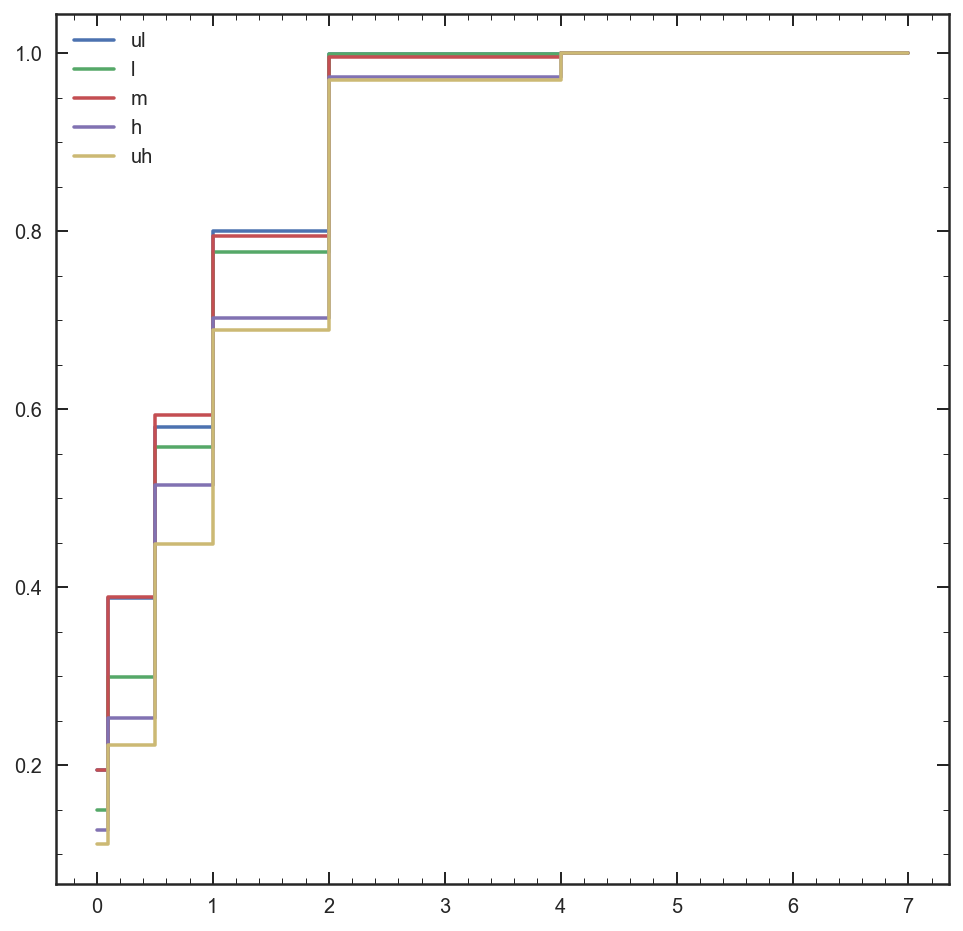

In [65]:
plt.figure(figsize=[8,8])
plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(ULT1,ULT2,ULT3,ULT4,ULT5,ULT6), label = 'ul')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(LT1,LT2,LT3,LT4,LT5,LT6), label = 'l')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(MT1,MT2,MT3,MT4,MT5,MT6), label = 'm')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(HT1,HT2,HT3,HT4,HT5,HT6), label = 'h')

plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
        Cumlative_dist(UHT1,UHT2,UHT3,UHT4,UHT5,UHT6), label = 'uh')
plt.legend()
# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([ULT1,ULT1,ULT2,ULT3,ULT4,ULT5,ULT6],16,axis=1),
#                  np.percentile([ULT1,ULT1,ULT2,ULT3,ULT4,ULT5,ULT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([LT1,LT1,LT2,LT3,LT4,LT5,LT6],50,axis=1))

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([LT1,LT1,LT2,LT3,LT4,LT5,LT6],16,axis=1),
#                  np.percentile([LT1,LT1,LT2,LT3,LT4,LT5,LT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([MT1,MT1,MT2,MT3,MT4,MT5,MT6],50,axis=1)) 

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([MT1,MT1,MT2,MT3,MT4,MT5,MT6],16,axis=1),
#                  np.percentile([MT1,MT1,MT2,MT3,MT4,MT5,MT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([HT1,HT1,HT2,HT3,HT4,HT5,HT6],50,axis=1)) 

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([HT1,HT1,HT2,HT3,HT4,HT5,HT6],16,axis=1),
#                  np.percentile([HT1,HT1,HT2,HT3,HT4,HT5,HT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

# plt.figure(figsize=[8,8])
# plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([UHT1,UHT1,UHT2,UHT3,UHT4,UHT5,UHT6],50,axis=1)) 

# plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
#                  np.percentile([UHT1,UHT1,UHT2,UHT3,UHT4,UHT5,UHT6],16,axis=1),
#                  np.percentile([UHT1,UHT1,UHT2,UHT3,UHT4,UHT5,UHT6],84,axis=1), 
#                  step = 'pre',alpha = .3)

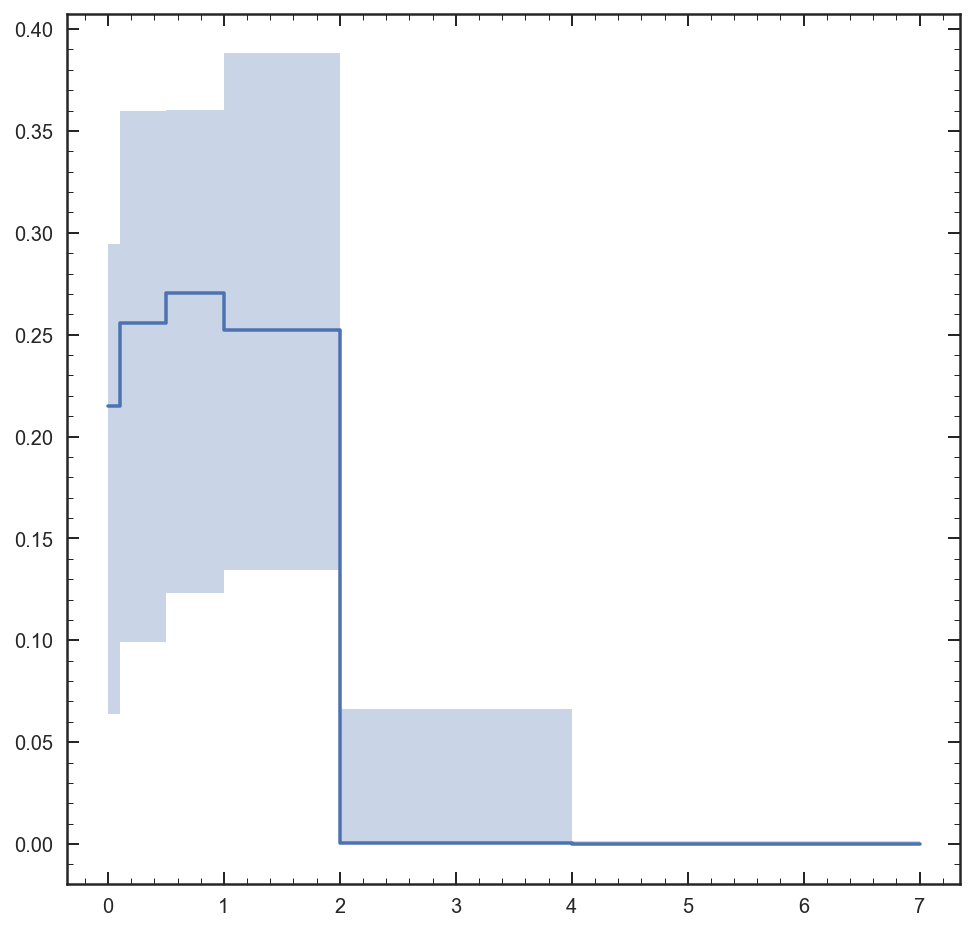

In [41]:
plt.figure(figsize=[8,8])
plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),np.percentile([T1,T1,T2,T3,T4,T5,T6],50,axis=1))

plt.fill_between(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
                 np.percentile([T1,T1,T2,T3,T4,T5,T6],16,axis=1),
                 np.percentile([T1,T1,T2,T3,T4,T5,T6],84,axis=1), 
                 step = 'pre',alpha = .3)

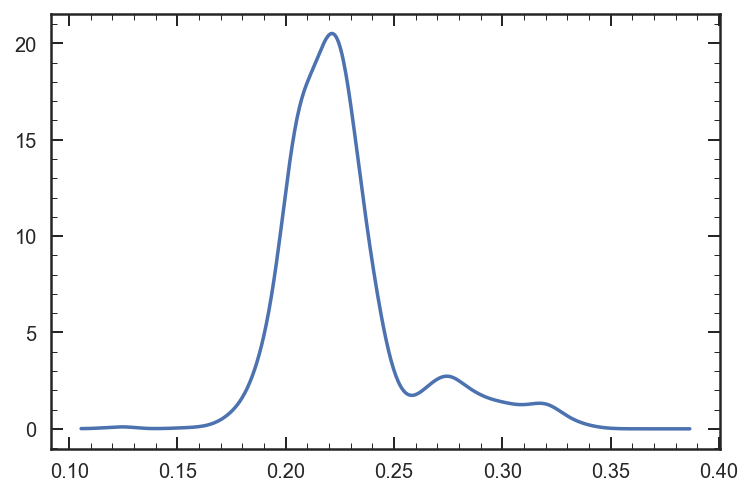

In [53]:
dres = np.load('../data/out_dict/GND_22774_nested_Bfit.npy').item()
bfZ, bft, bftau1, bftau2, bftau3, bftau4, bftau5, bftau6, bfz, bfd =  dres.samples.T

x,y = Get_posterior(bfZ, dres.logwt, dres.logz)
plt.plot(x,y)

x,y = Get_posterior(bfz, dres.logwt, dres.logz)
ZVAL = x[y==max(y)][0]

norm = bftau1 + bftau2 + bftau3 + bftau4 + bftau5 + bftau6

tau1,bfTAU1 = Get_posterior(bftau1, dres.logwt, dres.logz)
tau2,bfTAU2 = Get_posterior(bftau2, dres.logwt, dres.logz)
tau3,bfTAU3 = Get_posterior(bftau3, dres.logwt, dres.logz)
tau4,bfTAU4 = Get_posterior(bftau4, dres.logwt, dres.logz)
tau5,bfTAU5 = Get_posterior(bftau5, dres.logwt, dres.logz)
tau6,bfTAU6 = Get_posterior(bftau6, dres.logwt, dres.logz)

tval1 = tau1[bfTAU1==max(bfTAU1)][0]
tval2 = tau2[bfTAU2==max(bfTAU2)][0]
tval3 = tau3[bfTAU3==max(bfTAU3)][0]
tval4 = tau4[bfTAU4==max(bfTAU4)][0]
tval5 = tau5[bfTAU5==max(bfTAU5)][0]
tval6 = tau6[bfTAU6==max(bfTAU6)][0]

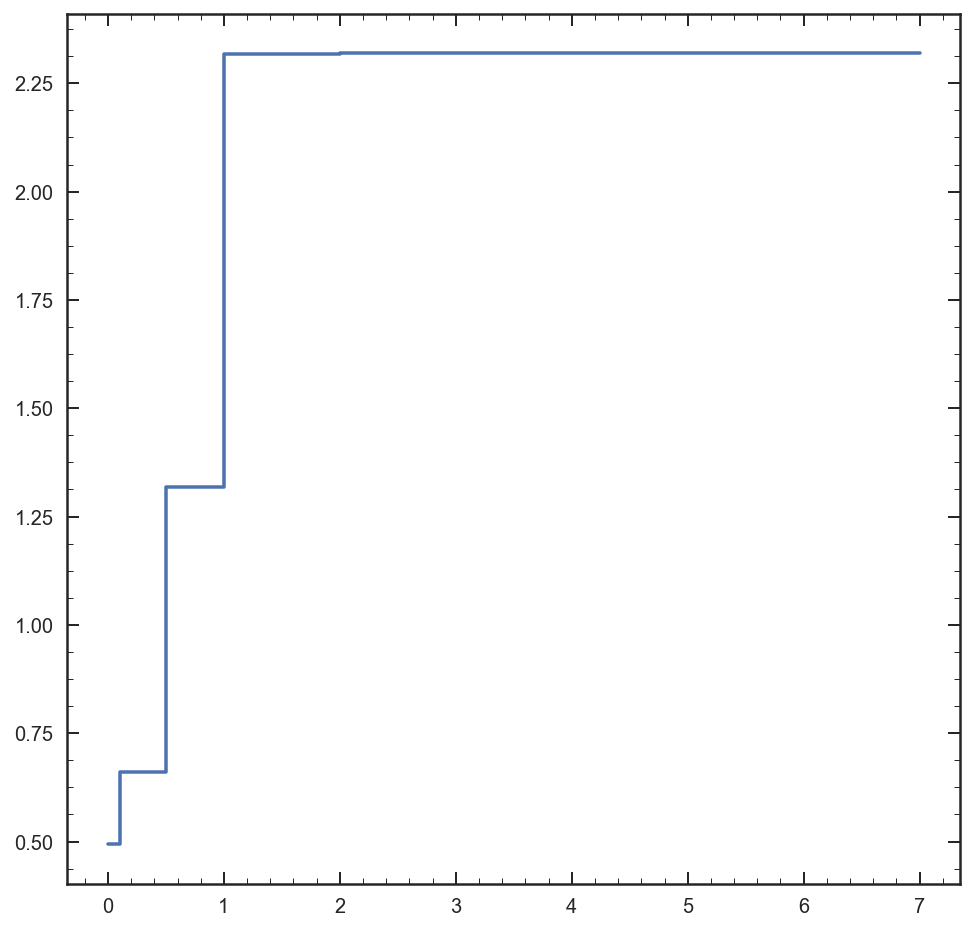

In [55]:
plt.figure(figsize=[8,8])
plt.step(np.array([0,0.1, 0.5, 1, 2, 4, 7]),
         [tval1,tval1,tval2 + tval1,tval3 + tval2 + tval1,tval4 + tval3 + tval2 + tval1,
          tval5 + tval4 + tval3 + tval2 + tval1,tval6 + tval5 + tval4 + tval3 + tval2 + tval1]) 

In [4]:
dres = np.load('../data/out_dict/GND_21156_nested_Bfit.npy').item()


In [5]:
from dynesty import plotting as dyplot


(<Figure size 1605.6x1605.6 with 100 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a73898ef0>,
       dtype=object))

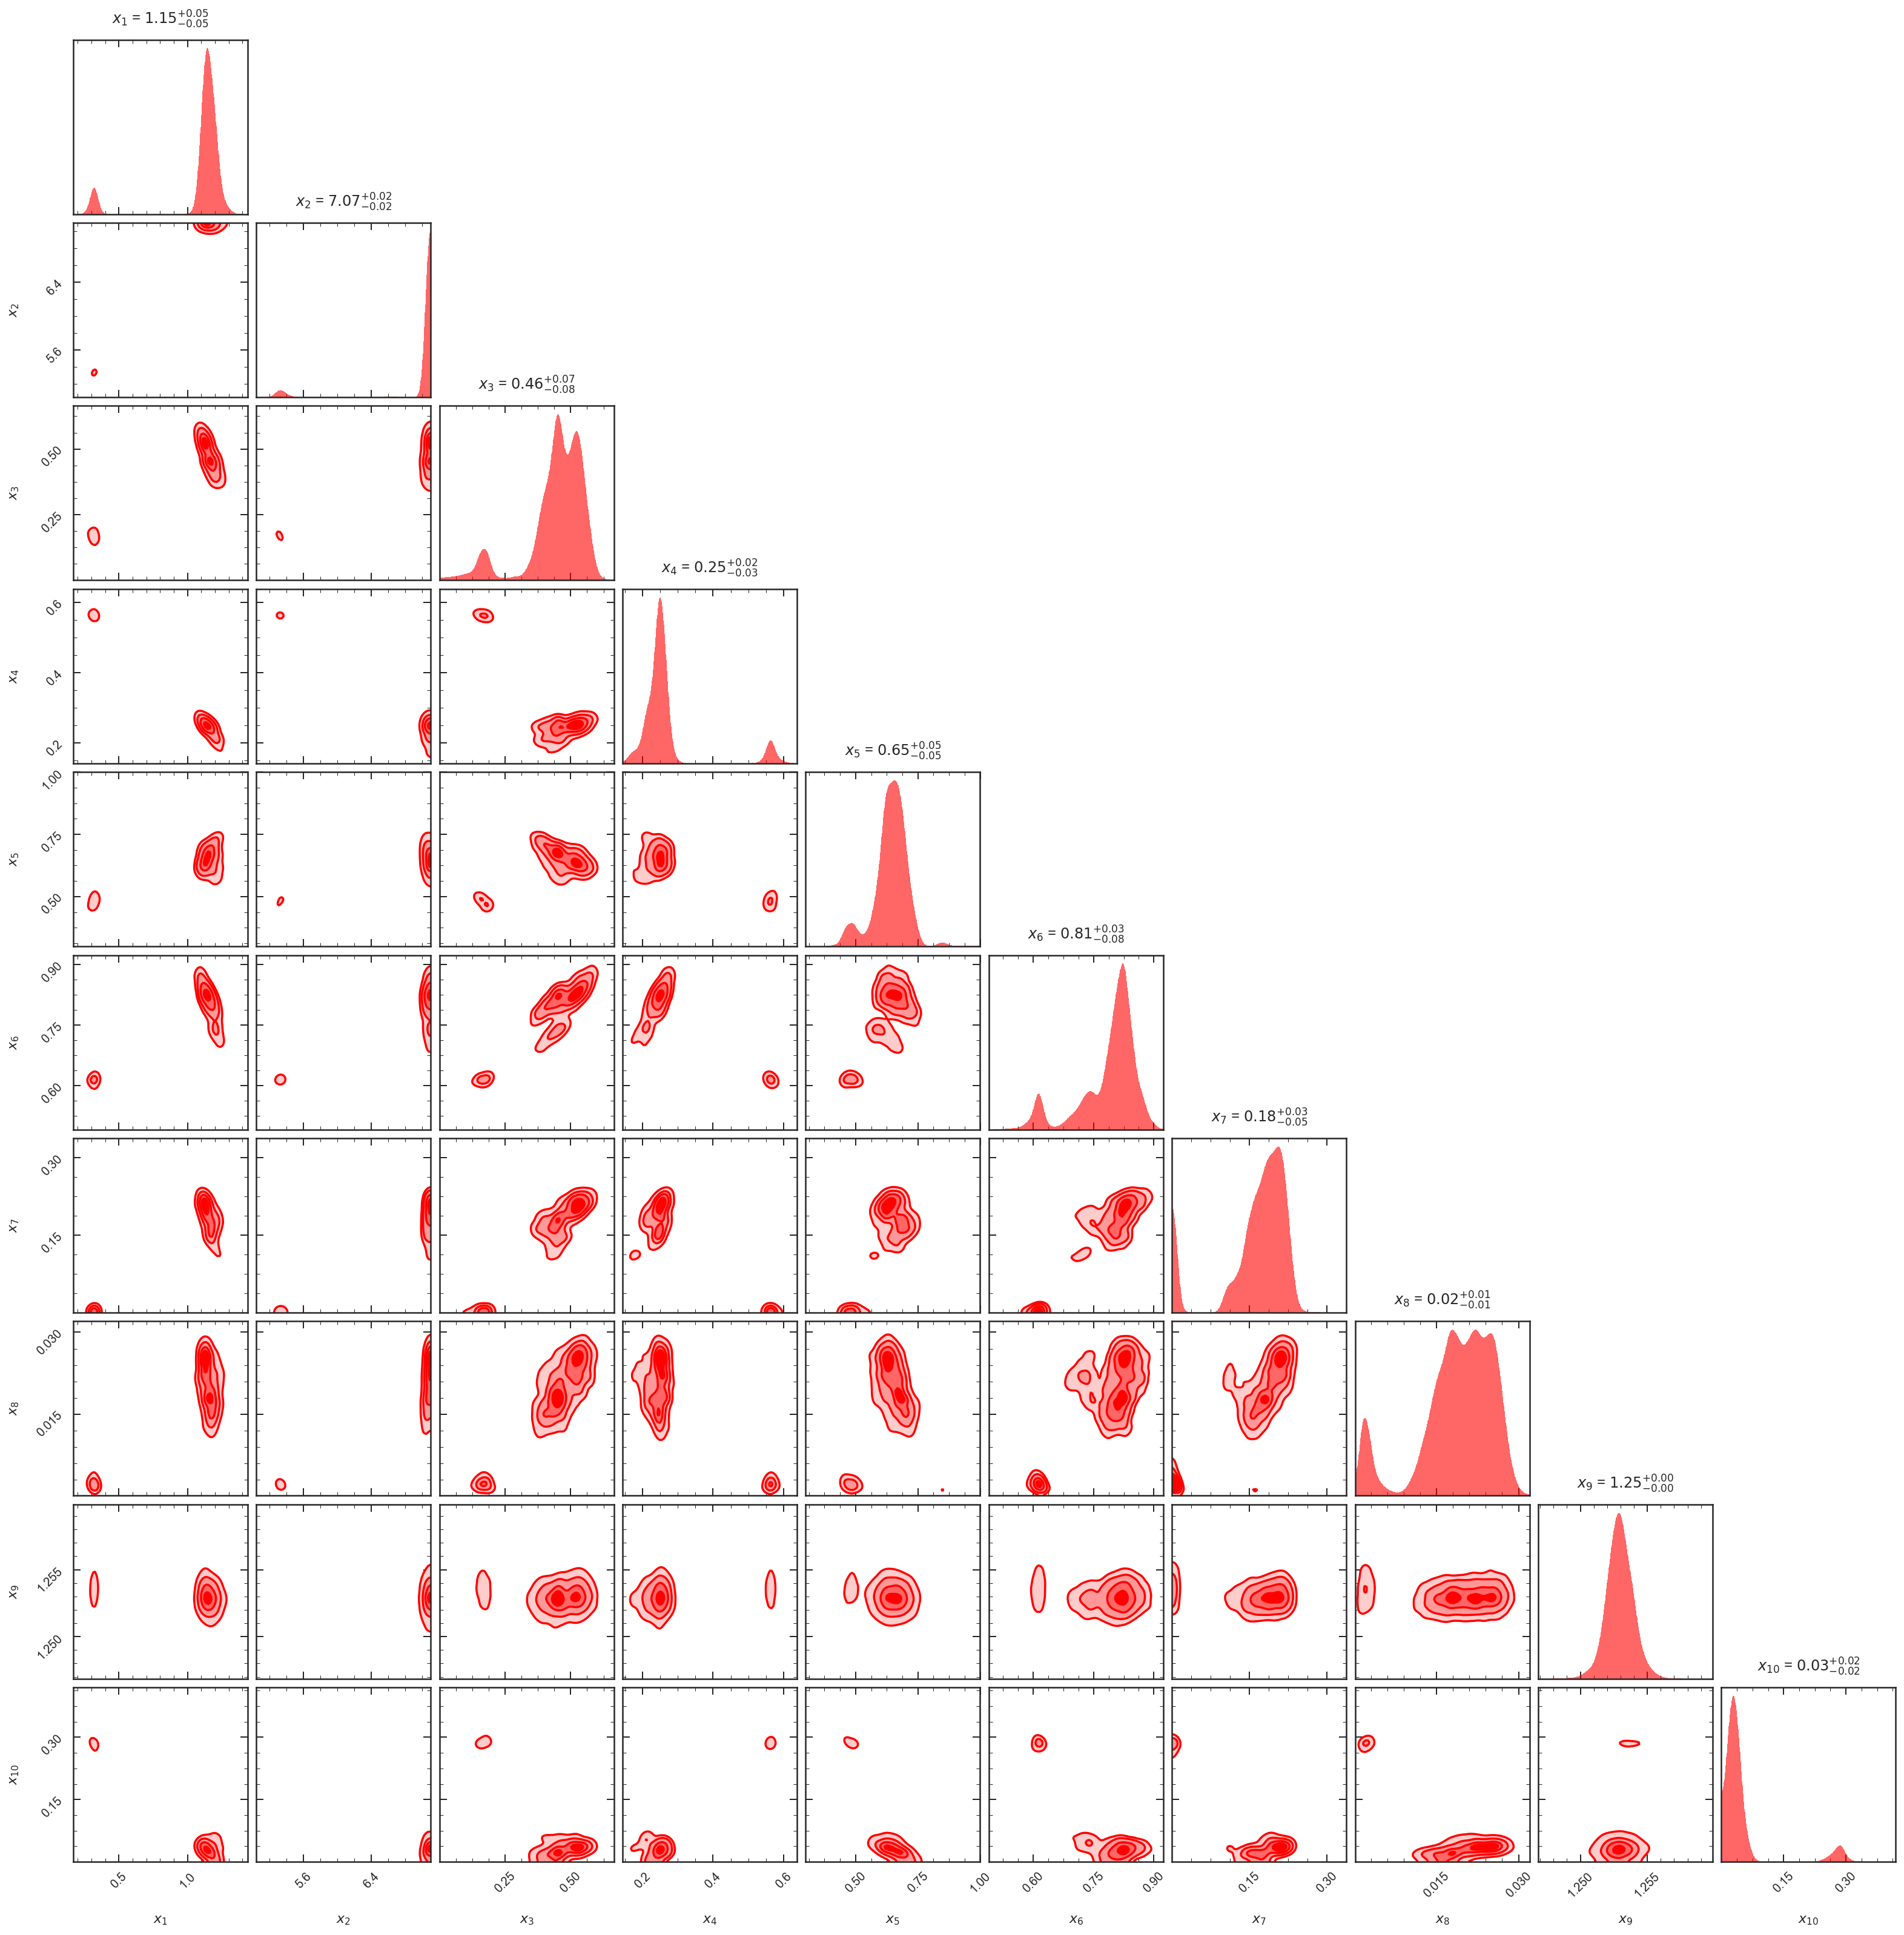

In [6]:
dyplot.cornerplot(dres, color='red', truths=None, truth_color='black',#labels = ['Z','t','$\\tau$','z','Av'],
                           show_titles=True, title_kwargs={'y': 1.05}, 
                           quantiles=None, max_n_ticks=3, )